# Part 2 - ML models on non-text features

Author: Laura Mercy

Date: 2022-12-12

Contact: laura.mercym@gmail.com

Now that we have cleaned our dataset and done some EDA in the previous notebook, Capstone- Part 1, we are ready to run some machine learning models to try and predict the popularity of a book. We are trying to figure out 2 things: 

1) Can we build a model that takes in the book's attributes that were available in our dataset (number of pages, length of the title, length of the description, genre, book format, whether or not the book is part of a series, whether or not the book has received awards, published year and number of books written by the author), and predict its popularity as a binary outcome, i.e yes (1) if the book would score more than 4 stars on average, no (0) if it would score less? And can we deduct which attributes are the most predictive?

2) Can we use the words in the title and the description to improve our model? Are they a good indicator of a book's popularity?

Since this is a binary classification problem, we will build 4 diffent models that can be used for classification and work on optimizing the hyperparamters:

1. Logistic Regression
2. KNN
3. Decision Tree
4. Random Forest

For hyperparameters optimization, we'll use the methods we've learned in class:
1. Creating a train & validation set and looping over the hyperparameters
2. Using cross-validation
3. Using a pipeline

We will work on the second question in separate notebooks (Capstone - Part 3 & 4), where we will vectorize the title and description using the Bag of Words technique, TF-IDF, Word2Vec and GloVe, and run the same machine learning models to see the impact on the model's performance.

We start by importing the librairies we'll need for our work.

In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#to display the full column
pd.set_option('display.max_columns', None)

#to scale the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#To split the dataset and do a GridSearch
from sklearn.model_selection import train_test_split, GridSearchCV

#To run machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#To reduce dimensionality
from sklearn.decomposition import PCA

#To score the model
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To get rid of warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

#To do cross validation
from sklearn.model_selection import cross_val_score

We import the clean dataset that we created in the previous notebook, and look at the first 5 rows to ensure this is what we were expecting.

In [2]:
#import data
books_df=pd.read_csv("data/books_df_clean.csv")
books_df.head()

,Unnamed: 0,title,description,pages,word_count_title,is_series,book_count_by_author,word_count_description,genre_Adult,genre_Adventure,genre_Biography,genre_Childrens,genre_Classics,genre_Contemporary,genre_Fantasy,genre_Fiction,genre_Historical,genre_Historical Fiction,genre_History,genre_Horror,genre_Islam,genre_Literature,genre_Magic,genre_Mystery,genre_Nonfiction,genre_Novels,genre_Paranormal,genre_Poetry,genre_Romance,genre_Science Fiction,genre_Thriller,genre_Urban,genre_Young Adult,genre_Other,format_Audiobook,format_Hardcover,format_Mass Market Paperback,format_Paperback,format_ebook,has_awards,publish_year,is_popular
0,0,The Hunger Games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,374,3,1,12,147,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,2008,1
1,1,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,870,8,1,24,136,0,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,2004,1
2,2,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,324,4,1,2,137,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,2006,1
3,3,Pride and Prejudice,Alternate cover edition of ISBN 9780679783268S...,279,3,0,14,100,1,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2000,1
4,4,Twilight,About three things I was absolutely positive.\...,501,1,1,14,55,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,2009,0


It looks good, but it seems that the index was duplicated in another columns, we'll remove it.

In [3]:
#Drop Unnamed
books_df.drop(['Unnamed: 0'],axis=1,inplace=True)

Now that we have our cleaned dataset, let's check its shape and make sure there are no more null values.

In [4]:
#check shape
books_df.shape

(39039, 41)

In [5]:
#Check for null values
books_df.isna().sum()

title                           0
description                     0
pages                           0
word_count_title                0
is_series                       0
book_count_by_author            0
word_count_description          0
genre_Adult                     0
genre_Adventure                 0
genre_Biography                 0
genre_Childrens                 0
genre_Classics                  0
genre_Contemporary              0
genre_Fantasy                   0
genre_Fiction                   0
genre_Historical                0
genre_Historical Fiction        0
genre_History                   0
genre_Horror                    0
genre_Islam                     0
genre_Literature                0
genre_Magic                     0
genre_Mystery                   0
genre_Nonfiction                0
genre_Novels                    0
genre_Paranormal                0
genre_Poetry                    0
genre_Romance                   0
genre_Science Fiction           0
genre_Thriller

We have 39,039 rows and 41 columns, which is the same as what we ended up with during the cleanup phase, and there are no null values. 

#### Assigning the variables

Before we can start modelling, we need to assign the independant variables X and the target variable y:

- Target variable y: whether or not a book is popular, represented by the column 'is_popular'
- Independant variables X: everything else, *except* the title and description, since they are text values.

In [6]:
#Assigning the variables
y=books_df['is_popular']
X=books_df.drop(['title','description','is_popular'],axis=1)

#### Splitting the dataset

We have one more step before starting modelling, and that is to split our dataset into a train and test set. Why are we doing this? 

The goal of a machine learning model is to be able to generalize from data it has seen and learned from, to data that it has never seen before. We don't want the model to either *overfit* or *underfit*. Overfitting is when the model has learned too much, meaning that it has picked up all the details and random noise in the data but is unable to apply those concepts to new data, which leads to poor performance. Underfitting on the other hand, is when the model hasn't learned enough and cannot generalize to the new data.

So if we were to train our model on the entire dataset, it would naturally overfit to it and we would have no way to test if the model works on data it has not seen before. So by splitting the dataset, we put aside a portion of the data (usually ~20%) that we don't touch until we are ready to assess the performance of the model, and that portion (the test set) acts as a proxy for future, new data.

However, since we want to do hyperparamater optimization without a pipeline first (we'll use a pipeline later), we need to further split the dataset. So far we have put 20% aside as our test set, and we are left with the other 80% that we will call the remainder. We can split this remainder into a train and validation set: the train set will be used to train the model, and the validation set will be used to assess the performance. That way, the test set remains absolutely unseen until we are ready to use it. 

To summarize, we'll have:
- a training set that we will use to train the model
- a validation set that we will use to optimize the hyperparameters
- a test set that we will use to assess the performance of the model

The training & vaidation set together constitute the remainder set.

SKLearn has a built-in function we can use to do the split. It split the data into 2 random sets, using arguments we give it. Here, we'll choose a 80/20 split, stratify on the 'y' to keep the proportions of the target variable the same between the 2 sets, and use a random state so the random split is always the same even if we re-run the cell. This is useful to ensure we work with the same train and set sets through our work. 

In [7]:
# Split the data to remainder and test set
X_rem, X_test, y_rem, y_test= train_test_split (X, y, test_size=0.2, stratify=y, random_state=1)

In [8]:
#Split the remainder to train and test set
X_train, X_val, y_train, y_val= train_test_split (X_rem, y_rem, test_size=0.2, stratify=y_rem, random_state=1)

Now that we have split our dataset, we want to make sure that we kept the proportion of the target variable y the same. This is was the stratify argument does, but let's check:

In [9]:
#Check that the class proportion have been preserved
print('Proportions in original data:')
print(y.value_counts()/len(y), '\n')

print('Proportions in remainder set:')
print(y_rem.value_counts()/len(y_rem), '\n')

print('Proportions in test set:')
print(y_test.value_counts()/len(y_test), '\n')

print('Proportions in train set:')
print(y_train.value_counts()/len(y_train), '\n')

print('Proportions in validation set:')
print(y_val.value_counts()/len(y_val), '\n')

Proportions in original data:
1    0.515664
0    0.484336
Name: is_popular, dtype: float64 

Proportions in remainder set:
1    0.515674
0    0.484326
Name: is_popular, dtype: float64 

Proportions in test set:
1    0.515625
0    0.484375
Name: is_popular, dtype: float64 

Proportions in train set:
1    0.51569
0    0.48431
Name: is_popular, dtype: float64 

Proportions in validation set:
1    0.515607
0    0.484393
Name: is_popular, dtype: float64 



They are all at 52/48, which is what we had when we looked at the class balance in the previous notebook. Great, we can now work on our first model!

# 1. Logistic Regression

Since the question we are trying to answer is a binary classification task (yes/no), we can use a logistic regression to fit our first model.

Let's take a look at the remainder set.

In [10]:
#Check X_rem
X_rem.head()

,pages,word_count_title,is_series,book_count_by_author,word_count_description,genre_Adult,genre_Adventure,genre_Biography,genre_Childrens,genre_Classics,genre_Contemporary,genre_Fantasy,genre_Fiction,genre_Historical,genre_Historical Fiction,genre_History,genre_Horror,genre_Islam,genre_Literature,genre_Magic,genre_Mystery,genre_Nonfiction,genre_Novels,genre_Paranormal,genre_Poetry,genre_Romance,genre_Science Fiction,genre_Thriller,genre_Urban,genre_Young Adult,genre_Other,format_Audiobook,format_Hardcover,format_Mass Market Paperback,format_Paperback,format_ebook,has_awards,publish_year
12988,479,10,0,1,231,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2017
4460,416,4,1,2,238,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019
19577,421,11,1,1,38,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2014
35307,338,5,1,14,99,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1999
12699,220,4,0,2,178,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1999


## 1.1 Vanilla LR

Let's train this very first model on the train and validation set. We won't scale the data either, just to have a baseline.

In [11]:
#Instantiate a vanilla LR model with unscaled data
lr=LogisticRegression()

#Fit the model on train data
logreg=lr.fit(X_train, y_train)

#Score the model
print("Train score: ",logreg.score(X_train,y_train))
print("Validation score: ",logreg.score(X_val,y_val))

Train score:  0.6503762407941083
Validation score:  0.6430286537538018


Considering that we would have a 52% chance of picking the right class without a model, a 64% accuracy on the validation set is not too bad. Let's see if we can improve it though. 

First, we know that the data is not on the same scale, as we have different measurements (number of pages, dummy variables, etc.) We can use a StandardScaler to reset all the variables on the same scale. Unlike a MinMax Scaler which normalizes the data (all the values are between 0 and 1), the standard scaler standardizes the data, meaning that it centers the data around 0 (the mean is 0 and the standard deviation is 1). This is usually more used than the MinMax Scaler, so we will use it for now, until we run a pipeline so we can try different scalers.

In [12]:
#Scale the train/val with a Standard Scaler

# instantiate the scaler
scaler=StandardScaler()

# fit the scaler to the X_train data
scaler=scaler.fit(X_train)

# transform both the X_train and X_test data with the fitted scaler
X_train_ss=scaler.transform(X_train)
X_val_ss=scaler.transform(X_val)

Now that the data is scaled, we can fit the same model as before.

In [13]:
#Instantiate a vanilla LR model on train/val with scaled data
lr=LogisticRegression()

#Fit the model on train data
logreg=lr.fit(X_train_ss, y_train)

#Score the model
print("Train score: ",logreg.score(X_train_ss,y_train))
print("Validation score: ",logreg.score(X_val_ss,y_val))

Train score:  0.6558597502401537
Validation score:  0.6543941091724027


The score on the validation set is a bit better, 65.4% vs. 64.3% earlier. 

To optimize the hyperparameter C (the regularization), we can loop over its value and plot the results to see how if impacts the accuracy.

In [14]:
# Defining a range of C values
c_values = [.00000001,.0000001,.000001,.00001,.0001,.001,.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# Loop over the C values
for value in c_values:
    
    # Instantiate a logreg model and fit to the train scaled set
    logreg = LogisticRegression(C=value, random_state=1).fit(X_train_ss, y_train)
    
    # Score on the train set and append this accuracy to the empty list
    train_accuracies.append(logreg.score(X_train_ss, y_train))
    
    # Score on the validation set and append this accuracy to the empty list
    validation_accuracies.append(logreg.score(X_val_ss, y_val))

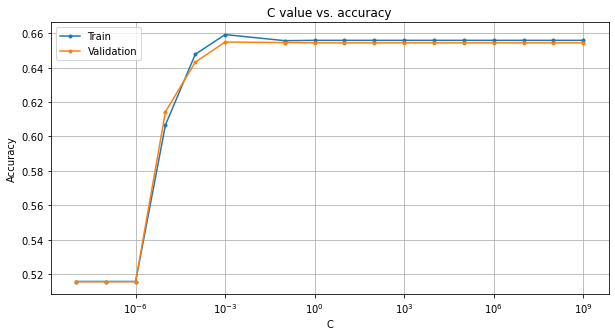

In [15]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('C value vs. accuracy')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

The accuracy seems to hover around 66%, and the best C seems to be 0.01. 

Instead of training and scoring the model on one random split of the dataset, we could try different random splits and see what the score is. Realistically, we can't do this manually but we can use a built-in function called K-fold cross validation that splits the data between train and validation sets K times, and averages all the scores to give a final accuracy score of the model. Let's try it.

## 1.2 Using Cross Validation

We will loop over the same C values, but instead use a 5-fold cross validation to average the scores. We will plot the results to see what the best C is.

Another point to note is that with a cross-validation, we don't need to have a train and validation set, the function splits it automatically. 
So we will run the cross-validation directly on the remainder and test set. Before we start, let's scale the remainder set with a StandardScaler, since it seemed to be performing better than unscaled data.

In [16]:
#Scale the remainder/test with a Standard Scaler

# instantiate the scaler
scaler=StandardScaler()

# fit the scaler to the X_train data
scaler=scaler.fit(X_rem)

# transform both the X_train and X_test data with the fitted scaler
X_rem_ss=scaler.transform(X_rem)
X_test_ss=scaler.transform(X_test)

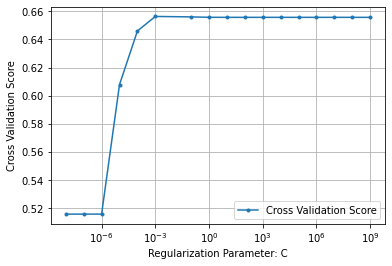

The best model has C =  0.001


In [17]:
#Store the results
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Looping over c

for c in C_range:
    my_logreg = LogisticRegression(C=c,random_state=1)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(my_logreg, X_rem_ss, y_rem, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

The highest average of cross validation scores seems to be when C=0.001. We can run another model with this optimized hyperparameter.

In [20]:
#Instantiate the final LR model with C=0.001
lr=LogisticRegression(C=0.001)

#Fit the model on train data
final_logreg=lr.fit(X_rem_ss, y_rem)

#Score the model
print("Remainder score: ",final_logreg.score(X_rem_ss,y_rem))
print("Test score: ",final_logreg.score(X_test_ss,y_test))

Remainder score:  0.6570714994716788
Test score:  0.6380635245901639


The performance on the test set is a bit lower than before, but we were only testing on the validation set. This is a larger dataset so it makes sense that the performance is not as good.

## 1.3 Using a Pipeline

That's a lot of steps, and we haven't even tried all of the hyperparameters yet! We could try different scalers, different regularization methods, different solvers... Thankfully, SK Learn has a method called pipeline that allows us to set various parameters and returns the combination that returns the best performance.

Before we start, let's look at the parameters we want to try:
- Penalty: this is the regularization method; L2 as default for Ridge, and L1 for Lasso
- C: this is the inverse of the regularization strength, i.e the lowest the value, the strongest the regularization)
- Scaler: we'll try without a scaler, and with 3 different types: MinMax, Standard and Robust
- PCA: this stands for Principal Components Analysis, which allows to reduce the number of dimensions by transforming the features in vectors of the direction of the greatest variance. We can also select the number of PCA we want to keep (n_components) or the threshold of the proportion of the variance explained. This is what we will do here.

We'll set n_jobs to -1 to limit the number CPU used to run the pipeline, and random state to 1 to ensure we always have the same results.

We'll proceed in 5 steps:
1. Set up a pipeline
2. Set up the parameter grid
3. Instantiate a cross validation on all the parameters above
4. Scoring the best model
5. Instantiating a fitting the final model with the best parameters

In [21]:
# Set up a pipeline
pipeline = Pipeline([('scaler', StandardScaler()), 
                        ('dim_reducer', PCA()), 
                        ('model', LogisticRegression())])

In [22]:
# Defining several C values
c_values = [.00000001,.0000001,.000001,.00001,.0001,.001,.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

# Setttin up the parameter grid
param_grid = [
    
    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values},
    
    # l2 with PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1)],
     'model__C': c_values}
]

In [23]:
# Instantiate the grid search with CV=5
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5,n_jobs=-1, verbose=1)

# Fit the logreg grid search on the untransformed Remainder set
fitted_gs = gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 680 candidates, totalling 3400 fits


/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lauramercy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [24]:
#Getting the best model
fitted_gs.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=100, n_jobs=-1, random_state=1))])

In [25]:
# Scoring the best accuracies
print(f"Remainder Accuracy: {fitted_gs.score(X_rem, y_rem)}")
print(f"Test Accuracy: {fitted_gs.score(X_test, y_test)}")

Remainder Accuracy: 0.6565591879862956
Test Accuracy: 0.6363985655737705


Based on the results of this pipeline, the best performance will be with a Logistic Regression that has the following parameters:
- C=100
- Scaler = MinMax Scaler
- No PCA

Although we have already scored the model and got an accuracy of 63.6% on the test score, we can instantiate and fit our final model below.

In [26]:
# define steps with the specified objects and parameters
estimators = [
    ('standard_scaling', MinMaxScaler()),
    ('logreg', LogisticRegression(C=100, n_jobs=-1, random_state=1, max_iter=1000))
]

# create pipeline object
logreg = Pipeline(estimators)

# fit the pipeline to the untransformed training data
logreg.fit(X_rem, y_rem);

# accuracy scores
print(f'remainder accuracy: {logreg.score(X_rem, y_rem)}')
print(f'test accuracy: {logreg.score(X_test, y_test)}')


remainder accuracy: 0.6564631295827863
test accuracy: 0.6371670081967213


63.7% accuracy is not great, but it's better than chance. What seems a bit strange is that it is a sligtly lower accuracy (only 0.1 percentage points) than what we got above with a Standard Scaler and C=0.001. 

## 1.4 Looking at other performance metrics 

Since the class we are trying to predict, whether or not a book is popular, is pretty much balanced (52/48), we have only focused on the accuracy until now. However, we could also look at precision, recall and F1 score using SK Learn confusion matrix and classificiation report.

In [27]:
# get predicted y values for the test set
y_pred_lr = logreg.predict(X_test)

In [28]:
# generate confusion matrix
cf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

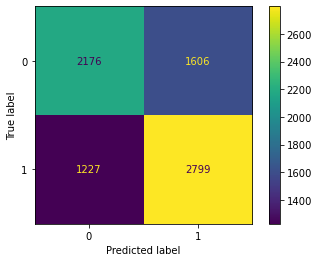

In [29]:
# plot the confusion matrix
ConfusionMatrixDisplay(cf_matrix_lr).plot()
plt.show()

The confusion matrix shows that out of the 7,808 entries in the test set, our model predicted correctly 2798 positives and 2171 negatives. This is the accuracy: correct results over the total of entries ( (2171+2798)/7808 = 63.6%).

The precision focuses more on minimizing the false positives, i.e how many true positives were predicted over the total of positives predicted (2798 / (2798+1611) = 63.4%. In our case, a false positive would be predicting that a book is popular when it's not.

The recall on the other hand minimizes the false negatives, i.e how many true positives were predicted over the total actual positives (2798 / (1228 + 2798) = 69.4%. In our case, a false negative would be prediciting that a book is not popular when it is.

Since for this particular business question precision and recall are just as important, we can look at F1, which is the harmonic mean of precision and recall.

We can visualize all those score in the classification report below.

In [32]:
#Print classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      3782
           1       0.64      0.70      0.66      4026

    accuracy                           0.64      7808
   macro avg       0.64      0.64      0.63      7808
weighted avg       0.64      0.64      0.64      7808



Since we have a balanced classififcation problem and we care equally about the fasle positives and false negative, we will keep looking at accuracy as our main performance metric, but this is good to know that we have other metrics to look at if needed.

## 1.3 Interpreting the coefficients

One of the main advantages of a logistic regression model is its interpretability. We can pull the coefficients associated with each feature, and assess their predictability power. 

We will use our best Logistic Regression model, Standard Scaler with C=0.001 and plot the 5 most predictive coefficients.

In [33]:
#putting the coef in a dataframe
coef_df=pd.DataFrame(final_logreg.coef_[0],X.columns)
coef_df.sort_values(by=[0],ascending=False).head(10)

,0
pages,0.376369
is_series,0.328002
book_count_by_author,0.153781
genre_Poetry,0.137553
genre_Childrens,0.107782
format_ebook,0.106525
word_count_title,0.105027
genre_Classics,0.085282
genre_Nonfiction,0.080217
genre_Other,0.078920


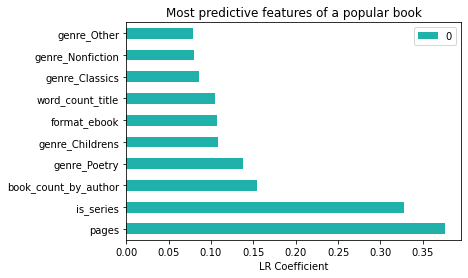

In [34]:
#Plotting the 5 most predicitive coefficients
coef_df.sort_values(by=[0],ascending=False).head(10).plot(kind='barh', color='lightseagreen')
plt.title("Most predictive features of a popular book")
plt.xlabel("LR Coefficient")
plt.show()

In order to interpret those coefficients, we can calulcate the odds ratio:

In [35]:
#putting the odds ratios in a dataframe
odds_df=pd.DataFrame(np.exp(final_logreg.coef_[0]),X.columns)
odds_df.sort_values(by=[0],ascending=False).head(5)

,0
pages,1.456984
is_series,1.388192
book_count_by_author,1.166235
genre_Poetry,1.147463
genre_Childrens,1.113805


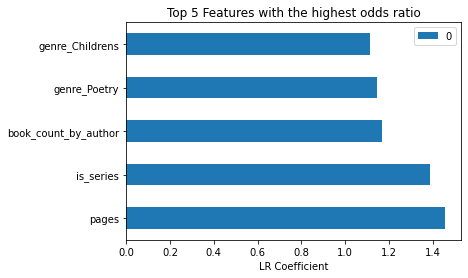

In [36]:
#Plotting the 5 highest odds ratios
odds_df.sort_values(by=[0],ascending=False).head(5).plot(kind='barh')
plt.title("Top 5 Features with the highest odds ratio")
plt.xlabel("LR Coefficient")
plt.show()

We interpret those odds ratios as "A book being part of a series has 1.38 times the odds to be popular than a book not being part of a series".

The length of a book, the number of books that the author has listed on the Best Book Ever list and whether or not a book is part of a series increases the odds of a book being popular on the Goodreads' list. 

As we have seen during the EDA phase, the genres are not distributed evenly across the dataset, in fact Poetry represents only 2.7% of all books in the list, but 70% of the Poetry books are popular.

# 2. KNN

K Nearest Neighbors is another type of supervised machine learning model, which performs well with boundaries that are not linear (no straight lines). It classifies the data based on the assumption that the observations that are the closest are the most similar. The hyperparameter K is the number of nearby observations to use in the algorithm. Since the model uses a majority vote to classify the data based on the K observations nearby, we usually use an odd value for K to avoid a tie. 

The downside of KNN models is that they are very computationally expensive.

## 2.1 Vanilla KNN

Now that we know how pipeline works, we can use one to fit a basic KNN model and see how it performs. We will choose K=5 by default.

In [37]:
# Setting up a pipeline with unscaled data

estimators = [
    ('standard_scaling', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# create pipeline object
pipe = Pipeline(estimators)

# fit the pipeline to the untransformed training data
pipe.fit(X_rem, y_rem);

# accuracy scores
print(f'Remainder accuracy: {pipe.score(X_rem, y_rem)}')
print(f'Test accuracy: {pipe.score(X_test, y_test)}')


Remainder accuracy: 0.7707085908232205
Test accuracy: 0.6506147540983607


The test accuracy is already better than with the logitic regression model at about 65%, however the remainder accuracy is much higher than the test, which is a sign of overfitting. Let's loop over the K value and visualize the accuracies to have a better idea of the KNN performance. 

As we have seen above, we want to use the train and validation set for this optimization, to avoid overfitting to the test data.

In [38]:
#Looping over K and visualizing - using train/val sets
#This takes a while to run

train_acc=[]
val_acc=[]

for k in range(1,61,4): #adding a step of 4 to get only odd numbers
    
    #Instantiate the model
    knn=KNeighborsClassifier(n_neighbors=k)

    #Fit the model on train data
    my_knn=knn.fit(X_train_ss, y_train)

    #Append the list
    train_acc.append(my_knn.score(X_train_ss,y_train))
    val_acc.append(my_knn.score(X_val_ss,y_val))

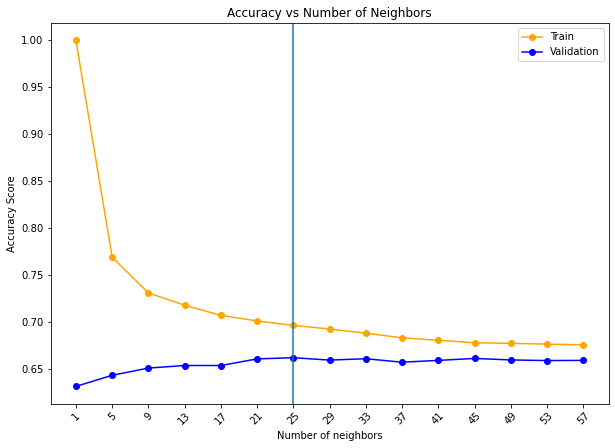

In [39]:
#Visualize
plt.figure(figsize=(10, 7))
plt.plot(range(1,61,4),train_acc,label="Train", color='orange',marker='o')
plt.plot(range(1,61,4),val_acc, label='Validation',color='blue',marker='o')
plt.xticks(range(1,61,4),rotation=45)
plt.axvline(25)
plt.ylabel("Accuracy Score")
plt.xlabel("Number of neighbors")
plt.title('Accuracy vs Number of Neighbors')
plt.legend()
plt.show()

A K value between 25 and 33 seems to be the most appropriate to avoid overfitting while maximizing the accuracy. Let's fit a model with K=25 on the standard scaled remainder and test set.

In [40]:
#Instantiate the model
knn=KNeighborsClassifier(n_neighbors=25)

#Fit the model on train data
my_knn=knn.fit(X_rem_ss, y_rem)

#Score the model
print(f'Remainder accuracy: {my_knn.score(X_rem_ss,y_rem)}')
print(f'Test accuracy: {my_knn.score(X_test_ss,y_test)}')


Remainder accuracy: 0.6955268803432487
Test accuracy: 0.6574026639344263


We get a slightly higher accuracy score than before, but more importantly the remainder score is closer to the test score, which means our model doesn't overfit anymore.

## 2.2 Cross Validation

Just like with the Logistic Regression model, we can use a cross vaidation to optimize the K value. We will use directly the remainder and test set, as the CV function splits the remainder set into train & validation sets for us. We will also use the Standard Scaled data.

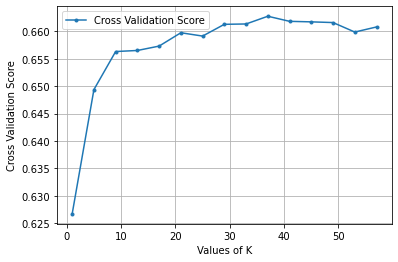

The best model has K =  37


In [41]:
#finding the best K with cross validation

#Store the results
cross_validation_scores = []

N_range = np.array(range(1,61,4))
#Looping over n

for k in N_range:
    my_knn = KNeighborsClassifier(n_neighbors=k)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(my_knn, X_rem_ss, y_rem, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(N_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('Values of K')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has K = ",N_range[which_max])



The best model has K=37. We know that a GridSearch can achieve the same results, but let's try it:

In [42]:
#Same things with a Gridsearch
my_knn = KNeighborsClassifier()
grid_search = GridSearchCV(my_knn, {"n_neighbors": range(1,61,4)})

grid_search.fit(X_rem_ss, y_rem) #fit on scaled data

print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'n_neighbors': 37}


Now that we have narrowed down the K value to a few possiilities, we can run a pipeline to figure out the best scaler and best K value.

## 2.3 Pipeline

In [43]:
#Trying different parameters with a pipeline

estimators = [
    ('scaling', StandardScaler()),
    ('model', KNeighborsClassifier())
]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)


# Parameter grid
param_grid = [
    
    # knn without PCA
    {'scaling': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'model': [KNeighborsClassifier()],
     'model__n_neighbors': [25,33, 37]},
]

# instantiate cross-validated grid search object with the steps and parameter grid
grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

# fit the grid to the unprocessed remainder data
grid.fit(X_rem, y_rem);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [44]:
# check the most optimal model
grid.best_estimator_

Pipeline(steps=[('scaling', RobustScaler()),
                ('model', KNeighborsClassifier(n_neighbors=37))])

Finally, we fit the final KNN model with the best parameters.

In [45]:
#Instantiate the model with the best parameters

# define steps with the specified objects and parameters
estimators = [
    ('robust_scaler',RobustScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=37))
]

# create pipeline object
final_knn = Pipeline(estimators)

# fit the pipeline to the untransformed training data
final_knn.fit(X_rem, y_rem);

# accuracy scores
print(f'Remainder accuracy: {final_knn.score(X_rem, y_rem)}')
print(f'Test accuracy: {final_knn.score(X_test, y_test)}')


Remainder accuracy: 0.7064134994076399
Test accuracy: 0.6780225409836066


We now have a 67.8% test accuracy on our best KNN model, better than our best Logistic Regression at 63.7%. The downside of this model however, besides the time it takes to run it, is that it is not as interpretable as a Logistic Regression and is very sensitive to distance and outliers.

## 2.4 Confusion matrix

In [46]:
# get predicted y values for the test set
y_pred_knn = final_knn.predict(X_test)

In [47]:
# generate confusion matrix
cf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

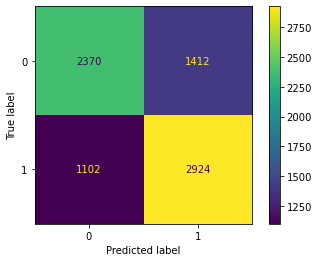

In [48]:
# plot the confusion matrix
ConfusionMatrixDisplay(cf_matrix_knn).plot()
plt.show()

In [49]:
#Print classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      3782
           1       0.67      0.73      0.70      4026

    accuracy                           0.68      7808
   macro avg       0.68      0.68      0.68      7808
weighted avg       0.68      0.68      0.68      7808



The claissification report shows an accuracy of 68% as expected, a precision (false positives) of 67%, a recall (fasle negative) of 73% and a F1 score of 70%. This is much better than the Logistic Regession score, and tells us that we have less chance of calling a false negative than a false positive. 

Let's run one more type of model to see if we can improve our scores even more.

# 3. Decision Tree & Random Forest

Decision Trees are another type of supervised models, which are also good for classification tasks and non-linear boundaries. In short, it is a series of binary decisions on 2 features of the dataset at each node of the tree. For example, is the book Fiction or non Fiction? Is the book longer than 300 pages? Is the book part of a series? etc... It is easy to intrepret and visuzalize, but can be unstable as different subsets of the data can lead to different results. They are not sensitive to distance, so we don't need to scale the data here.

## 3.1 Vanilla DT

As before, we'll start with a basic Decision Tree to have a baseline of the accuracy. We'll set a max_depth of 3 (maximum number of nodes) to avoid a long , complex tree and therefore risk of overfitting. We'll optimize the parameter in our next step.

In [50]:
#Instantiate the model
dct=DecisionTreeClassifier(max_depth=3)

#Fit the model on remainder data
my_dct=dct.fit(X_rem, y_rem)

#Score the model
print(f'Accuracy on remainder set: {my_dct.score(X_rem,y_rem)}')
print(f'Accuracy on test set: {my_dct.score(X_test,y_test)}')


Accuracy on remainder set: 0.6374755851557747
Accuracy on test set: 0.6230788934426229


We see that the accuracy score on the test set is still within the same range as earlier, although the lowest of all the scores we got so far at 62.3%. 

We can visualize our decision tree using a built-in function in SK Learn.

In [51]:
from sklearn.tree import plot_tree

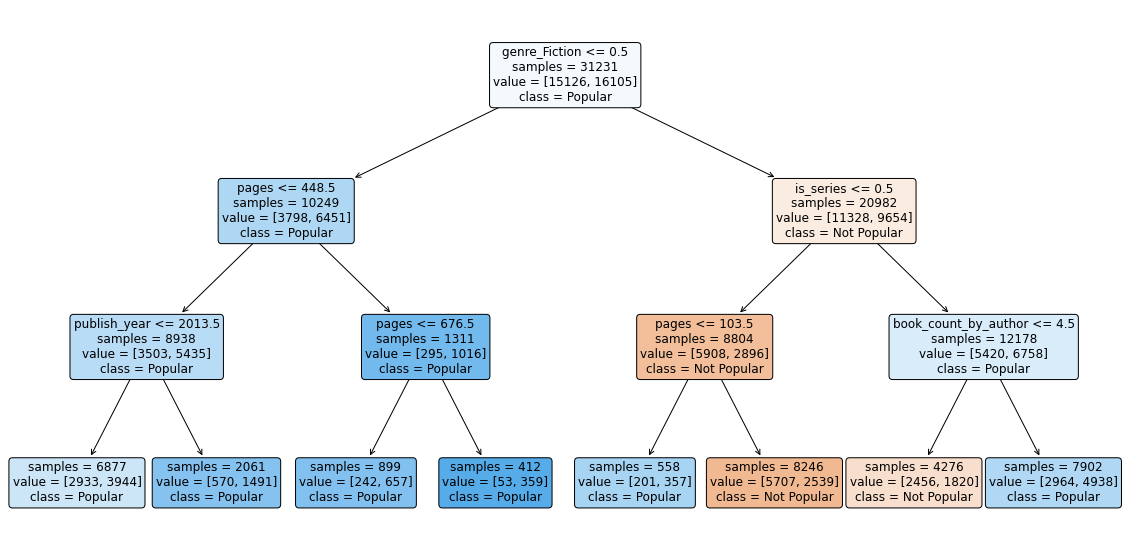

In [52]:
# Set the size
fig= plt.figure(figsize=(20,10))

#Plot the tree
plot_tree(my_dct, 
          feature_names=X.columns,
          class_names=["Not Popular","Popular"],
          rounded=True,
          impurity=False,
          filled=True,
          fontsize=12);

The Class indicates the decision made at each node, as shown by the color of the leaf. Each node is split into two decisions, left for 'True' and right for 'False'. So here we read:

- 'Is Fiction <=0.5 i.e is the book NOT Fiction?' -> if Yes, to the left node. Class is Popular, because 6451 of the 10249 non-fiction books are popular.
- Does the book have less than 449 pages? If no, to the right node. Class is Popular, because 1016 out of the 1311 non-fiction books that have more than 448 pages are popular
- And so on until then end...

## 3.2 Hyperparameter Optimization

The same way as we've done before, we loop over the hyperparamter and visualize the accuracy based on the max_depth value.

In [53]:
#Looping over M and visualizing - using train/val sets
#This takes a while to run

train_acc=[]
val_acc=[]

for m in range(1,20,1): 
    
    #Instantiate the model
    dct=DecisionTreeClassifier(max_depth=m)

    #Fit the model on train data
    my_dct=dct.fit(X_train, y_train)

    #Append the list
    train_acc.append(my_dct.score(X_train,y_train))
    val_acc.append(my_dct.score(X_val,y_val))

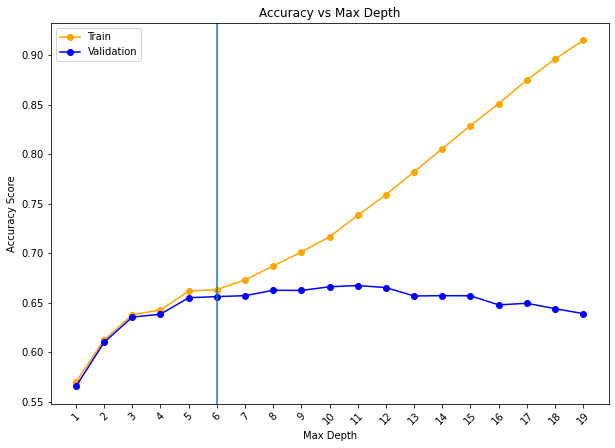

In [54]:
#Visualize
plt.figure(figsize=(10, 7))
plt.plot(range(1,20,1),train_acc,label="Train", color='orange',marker='o')
plt.plot(range(1,20,1),val_acc, label='Validation',color='blue',marker='o')
plt.xticks(range(1,20,1),rotation=45)
plt.axvline(6)
plt.ylabel("Accuracy Score")
plt.xlabel("Max Depth")
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()

We see here that the optimized max_depth seems to be 6, before the model starts overfitting. Let's fit our final model with this value.

In [55]:
#Instantiate the final model with M=6

dct=DecisionTreeClassifier(max_depth=6)

#Fit the model on remainder data
final_dct=dct.fit(X_rem, y_rem)

#Score the model
print(f'Accuracy on remainder set: {final_dct.score(X_rem,y_rem)}')
print(f'Accuracy on test set: {final_dct.score(X_test,y_test)}')


Accuracy on remainder set: 0.6608497966763792
Accuracy on test set: 0.6453637295081968


The accuracy on the test is not as good as with KNN, it scored 64.5%. We could try an ensemble of decisions trees, known as a Random Forest. This would allows us to mitigate some of the issues with the decision trees that we stated earlier.

## 3.3 Random Forest

Our research has shown that Random Forests have been quite effective at classification problems, in fact they have been used for predicting [a Book's Success in the New York Times Best Sellers List](https://github.com/scostap/goodreads_bbe_dataset).

Random Forests are made of individual, uncorrelated decision trees which each have a classification outcome (popular or not popular). The class with the most votes becomes the Random Forest's prediction. 

In [56]:
from sklearn.ensemble import RandomForestClassifier

Let's instantiate our first Random Forest, with 25 individual Decision Trees (the n_estimators)

In [57]:
#Instantiating the model
rf = RandomForestClassifier(n_estimators=25)
rf.fit(X_rem, y_rem)

RandomForestClassifier(n_estimators=25)

We can then score each tree individually and average their scores, or score the whole forest and see how it compares.

In [58]:
#Scoring each tree individually and averaging them, then scoring the forest

decision_tree_scores = []
for sub_tree in rf.estimators_:
    decision_tree_scores.append(sub_tree.score(X_rem, y_rem))
    
print("Performance on Remainder dataset:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {rf.score(X_rem, y_rem)}")

Performance on Remainder dataset:
Average Decision Tree: 0.8571739617687554
Random Forest: 0.9983670071403413


In [59]:
decision_tree_scores = []
for sub_tree in rf.estimators_:
    decision_tree_scores.append(sub_tree.score(X_test, y_test))

print("Performance on Test dataset:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {rf.score(X_test, y_test)}")

Performance on Test dataset:
Average Decision Tree: 0.609923155737705
Random Forest: 0.6976178278688525


This is clearly overfitting, the remainder set scored almost 100% while the test set scored 70%. 

Let's loop over n_estimators with decision stumps (depth of 1), which should prevent overfitting, and plot the results.

In [60]:
#Looping over n_estimators with max-depth=1
n_estimators_range = range(1, 150)

results = pd.DataFrame()
for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=1,random_state=1)

    rf.fit(X_rem, y_rem)
    
    rem_score = rf.score(X_rem, y_rem)
    test_score = rf.score(X_test, y_test)
    
    results = results.append(
        {"n_estimators": n_est, "remainder": rem_score, "test": test_score},
        ignore_index=True
    )
    
    print(n_est, end="\r")

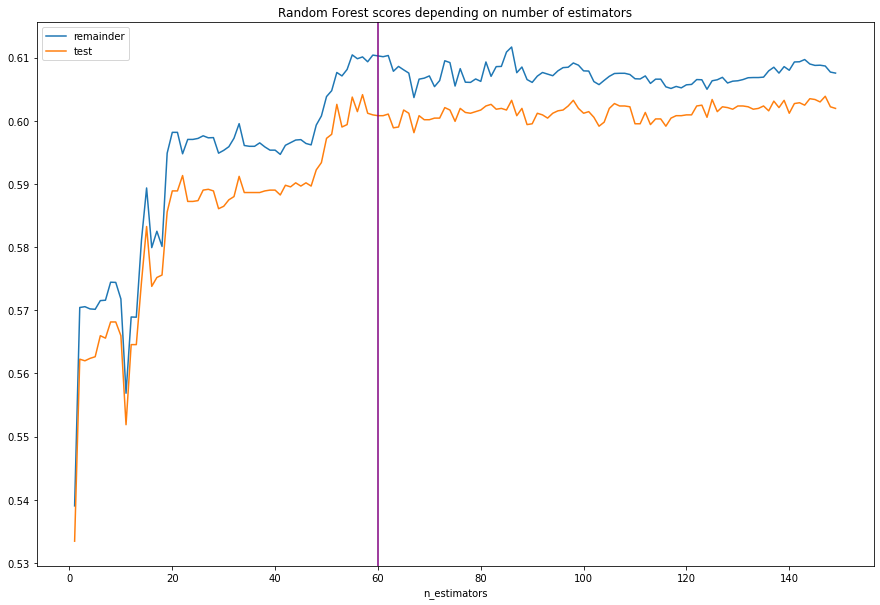

In [61]:
#plotting the results
plt.figure(figsize=(10, 7))
results.plot(x="n_estimators", y=["remainder", "test"], kind="line", ax=plt.gca(),figsize=(15,10))
plt.axvline(60,color="purple")
plt.legend()
plt.title("Random Forest scores depending on number of estimators")
plt.show()

We see that the accuracy increases sharply between 0 and 50 decision trees, but that it seems to stabilize after that. The Remainder and Test accuracy are pretty close to each other, which is a sign that our model is not overfitting. Let's pick a value of 60 for the number of trees.

One of the advantages of a random forest is that we can interpret the result by looking at the features importance:

In [62]:
#Putting the most important features in a dataframe

rf = RandomForestClassifier(n_estimators=60, max_depth=1,random_state=1)

rf.fit(X_rem, y_rem)

# Find the most important features
feature_df = pd.DataFrame(
    {"feature_importance": rf.feature_importances_},
    index=X.columns
)

feature_df=feature_df.sort_values(by='feature_importance', ascending=False)
feature_df.head(10)

,feature_importance
genre_Contemporary,0.166667
genre_Nonfiction,0.133333
genre_Novels,0.116667
is_series,0.100000
pages,0.083333
word_count_title,0.066667
genre_Fiction,0.066667
genre_Mystery,0.050000
publish_year,0.050000
format_ebook,0.033333


Now that we have selected an optimum number of trees, let's fin the best depth by looping over max_depth and plotting the results.

In [63]:
#Finding the best depth

#Same thing, but with max-depth=1
max_depth_range = range(1, 20,1)

results = pd.DataFrame()
for m in max_depth_range:
    rf = RandomForestClassifier(n_estimators=60, max_depth=m,random_state=1)

    rf.fit(X_rem, y_rem)
    
    rem_score = rf.score(X_rem, y_rem)
    test_score = rf.score(X_test, y_test)
    
    results = results.append(
        {"max_depth": m, "rem": rem_score, "test": test_score},
        ignore_index=True
    )
    
    print(m, end="\r")

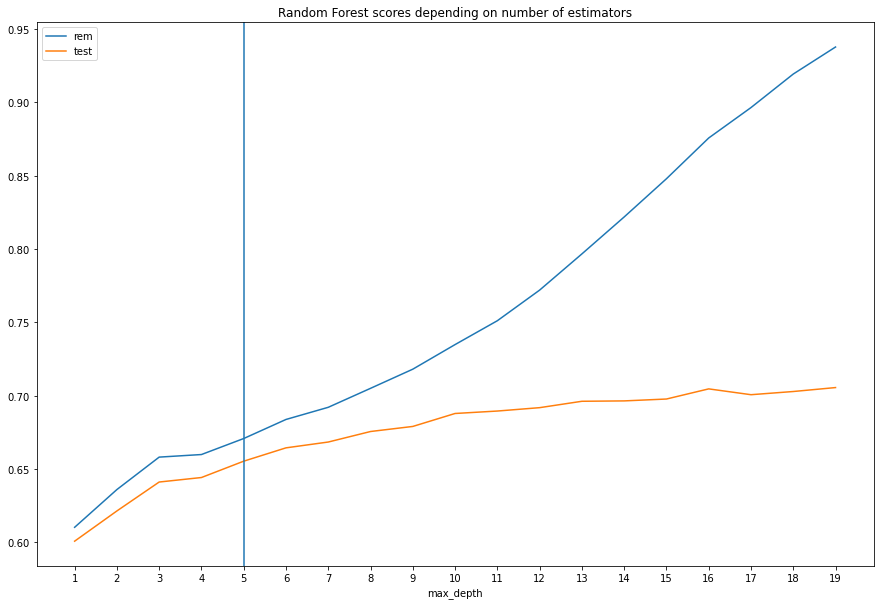

In [64]:
#plotting the results
plt.figure(figsize=(10, 5))
results.plot(x="max_depth", y=["rem", "test"], kind="line", ax=plt.gca(),figsize=(15,10))
plt.axvline(5)
plt.xticks(range(1,20,1))
plt.legend()
plt.title("Random Forest scores depending on number of estimators")
plt.show()

The 2 lines run parallel from 1 to 5 nodes, but start diverging after that with the Remainder set's accuracy increasing steadily while the Test set's accuracy flatlines. We will pick a max_depth of 5, as this is the point just before the lines start diverging.

Finally, we can instantiate our best model with n = 60 and max_depth = 5:

In [65]:
#Instantiating the best model, n=60, m=5

rf = RandomForestClassifier(n_estimators=60,max_depth=5,random_state=1)
rf.fit(X_rem, y_rem)

RandomForestClassifier(max_depth=5, n_estimators=60, random_state=1)

In [66]:
# Remainder Scores

decision_tree_scores = []
for sub_tree in rf.estimators_:
    decision_tree_scores.append(sub_tree.score(X_rem, y_rem))
    
print("Performance on Remainder dataset:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {rf.score(X_rem, y_rem)}")

Performance on Remainder dataset:
Average Decision Tree: 0.6145448432647048
Random Forest: 0.6708078511735135


In [67]:
#Test scores

decision_tree_scores = []
for sub_tree in rf.estimators_:
    decision_tree_scores.append(sub_tree.score(X_test, y_test))

print("Performance on Test data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {rf.score(X_test, y_test)}")

Performance on Test data:
Average Decision Tree: 0.604623463114754
Random Forest: 0.6553534836065574


Our Random Forest scored 65.5% accuracy on the test set, better than the individual decision tree we fitted earlier which scored 64.5%. 

We will again put the most important features in a dataframe for our final model:

In [68]:
#Putting the most important features in a dataframe

mrf = RandomForestClassifier(n_estimators=60, max_depth=5,random_state=1)

rf.fit(X_rem, y_rem)

# Find the most important features
feature_df = pd.DataFrame(
    {"feature_importance": rf.feature_importances_},
    index=X.columns
)

feature_df=feature_df.sort_values(by='feature_importance', ascending=False)
feature_df.head(10)

,feature_importance
is_series,0.142155
pages,0.134571
genre_Fiction,0.118724
book_count_by_author,0.085705
publish_year,0.084035
genre_Novels,0.072186
genre_Contemporary,0.068364
genre_Nonfiction,0.054757
genre_Mystery,0.040669
word_count_title,0.039475


<Figure size 432x288 with 0 Axes>

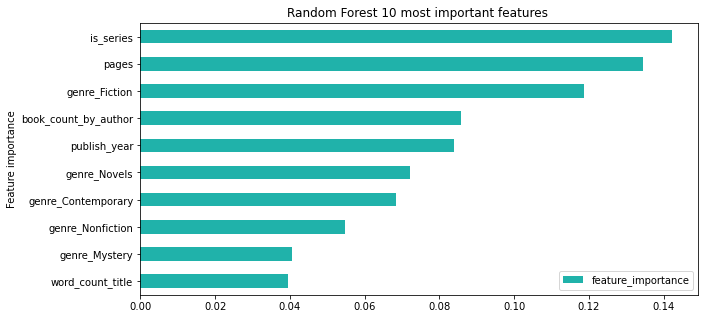

In [69]:
#Plotting the features
plt.figure()
feature_df.head(10).sort_values(by='feature_importance').plot(kind='barh',figsize=(10,5), color='lightseagreen')
plt.title("Random Forest 10 most important features ")
plt.ylabel("Feature importance")
plt.show()

We see that the most important features in the Random Forest model are whether or not the book is part of a series, the length of the book, whether it is Fiction or not, the number of books that the author has listed on the Goodreads' list, and the publish year. 3 of them are quite similar to what we saw when we plotted the Logistic Regression coefficients:

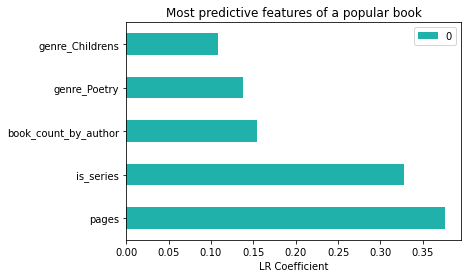

In [70]:
#Plotting the 5 most predicitive coefficients
coef_df.sort_values(by=[0],ascending=False).head(5).plot(kind='barh',color='lightseagreen')
plt.title("Most predictive features of a popular book")
plt.xlabel("LR Coefficient")
plt.show()

We could start drawing some conclusions as to what features of a book influence its popularity...

However as we've said earlier, analysis the influence of genre is quite complex due to the uneven distribution through the dataset. We could look isolate just the Fiction books since they represent the largest represented genre, and see how our best model performs on this subset.

# 4. Running our best model on just Fiction books

First, let's look at the popularity of the Fiction books.

In [71]:
books_df['is_popular'][books_df['genre_Fiction']==1].value_counts(normalize=True)

0    0.538092
1    0.461908
Name: is_popular, dtype: float64

It's not perfectly balanced, but close enough. Let's put them into a subset of the dataset:

In [72]:
#Creating a new dataframe with just fiction books
books_df2=books_df[books_df['genre_Fiction']==1]
books_df2.head(1)

,title,description,pages,word_count_title,is_series,book_count_by_author,word_count_description,genre_Adult,genre_Adventure,genre_Biography,genre_Childrens,genre_Classics,genre_Contemporary,genre_Fantasy,genre_Fiction,genre_Historical,genre_Historical Fiction,genre_History,genre_Horror,genre_Islam,genre_Literature,genre_Magic,genre_Mystery,genre_Nonfiction,genre_Novels,genre_Paranormal,genre_Poetry,genre_Romance,genre_Science Fiction,genre_Thriller,genre_Urban,genre_Young Adult,genre_Other,format_Audiobook,format_Hardcover,format_Mass Market Paperback,format_Paperback,format_ebook,has_awards,publish_year,is_popular
0,The Hunger Games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,374,3,1,12,147,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,2008,1


We'll reassign our X and y, but we will ignore all of the genres in this new X2.

In [73]:
#Assigning X2
X2=books_df2[['pages','word_count_title','is_series','book_count_by_author','word_count_description','format_Audiobook','format_Hardcover','format_Mass Market Paperback','format_Paperback','format_ebook','has_awards','publish_year']]

In [74]:
#Looking at X2
X2.head(1)

,pages,word_count_title,is_series,book_count_by_author,word_count_description,format_Audiobook,format_Hardcover,format_Mass Market Paperback,format_Paperback,format_ebook,has_awards,publish_year
0,374,3,1,12,147,0,1,0,0,0,1,2008


In [75]:
#Reassigning y
y2=books_df2['is_popular']

We will again split the dataset into train and test set, with the same arguments as earlier.

In [76]:
# Split the data to train and test set
X2_train, X2_test, y2_train, y2_test= train_test_split (X2, y2, test_size=0.2, stratify=y2, random_state=1)

In [77]:
#Instantiate the model with the best parameters

# define steps with the specified objects and parameters
estimators = [
    ('robust_scaler',RobustScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=37))
]

# create pipeline object
pipe = Pipeline(estimators)

# fit the pipeline to the untransformed training data
pipe.fit(X2_train, y2_train);

# accuracy scores
print(f'train accuracy: {pipe.score(X2_train, y2_train)}')
print(f'test accuracy: {pipe.score(X2_test, y2_test)}')


train accuracy: 0.6874374732028012
test accuracy: 0.6758765243902439


That scored just the same as before...We will leave it at that for now, and move on to the next part of our project, which is to analyze the text data contained in the title and description.

# Conclusion

We have run several supervised machine learning models, each with their advantages and drawbacks, and optimized over the hyperparameters using different techniques and visualization. We can recap our scores.

Model | Remainder | Test
:------|:-----------|:------
LR, Standard Scaler, C=0.001 | 65.7% | 63.8%
LR, MinMax Scaler, C=100 | 65.6% | 63.7%
KNN, Standard Scaler, K=25 | 69.5% | 65.7%
KNN, RobustScaler, K=37 | 70.6% | 67.8%
DT, unscaled, M=3 | 63.7% | 62.3%
DT, unscaled, M=6 | 66.1% | 64.5%
RF, unscaled, n=60, M=5 | 67.0% | 65.5%

The model that had the best performance is KNN with a RobustScaler and K=37, followed by the Random Forest. However, the accuracy scores are still pretty low, compared to chance which would give us 52%. 

We have also learned that some features had some influence on the classification task, such as whether the book is part of a series, the number of pages and the number of books that the authors has listed on the Goodreads' Best Book Ever list.

We will now move to Part 3 - Vectorizing Title and Description with CountVectorizer and TF-IDF.